# Cerate Cue Locations List

For each image, use the boudning box and the image size to find the:
- image center 
- object cue location 
- fixation location (5,10,15 degrees)

In [27]:
import cv2
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as patches

import glob

In [28]:
#imnum = '000000532761'; 
imnum = '000000579635'; 
bbx_xywh = (463,304,34,12)
#bbx_xywh = (117,191,65,46)
#bbx_xywh = (500,150,65,46)

ppd = 16

#read in image
#im = cv2.imread(f'/home/gridsan/vdutell/RosenholtzLab_shared/val2017_select/{imnum}.jpg')
im = cv2.imread(f'/home/gridsan/vdutell/RosenholtzLab_shared/cocop_stims/{imnum}.jpg')
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB) 


In [29]:
def find_fixation_location(img, bbx_xywh, eccentricity, ppd, plot=False):

    #get desired distance
    fd  = eccentricity * ppd
    
    ##TODO: Possibly base this off of distance from bbx edge rather than center.
    object_loc_center = (bbx_xywh[0] + (bbx_xywh[2]//2), bbx_xywh[1] + (bbx_xywh[3]//2))
    #object_loc_edge = 
    object_loc = object_loc_center
    
    #get image center
    imshape = np.shape(img)
    img_center = (imshape[1]//2, imshape[0]//2)
    
    #get angle to center
    dy = object_loc[1] - img_center[1]
    dx = object_loc[0] - img_center[0]
    theta = np.arctan2(dy,dx)
    
    #solve for fixation location
    fix_dy = np.sin(theta)*fd
    fix_dx = np.cos(theta)*fd
    #add or subtract position from object center based on quadrant
    if(fix_dy > object_loc[1]):
        fix_y = object_loc[1] + fix_dy
    else:
        fix_y = object_loc[1] - fix_dy
    if(fix_dx > object_loc[0]):
        fix_x = object_loc[0] + fix_dx
    else:
        fix_x = object_loc[0] - fix_dx

    #print(img_center, object_loc)
    #print(dy,dx,theta)
    #pring(fix_x, fix_y)
    #plotting
    if(plot):
        rect = patches.Rectangle((bbx_xywh[0], bbx_xywh[1]), bbx_xywh[2], bbx_xywh[3], linewidth=1, edgecolor='r', facecolor='none')
        fig,ax = plt.subplots()
        ax.imshow(im)
        ax.add_patch(rect)
        ax.scatter(*object_loc,label='object')
        plt.scatter(*img_center,label='center')
        plt.scatter(fix_x,fix_y,label='fixation')
        plt.legend()
        plt.show()

    return((fix_x,fix_y))

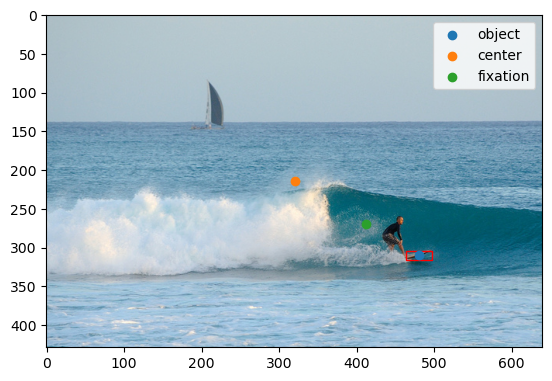

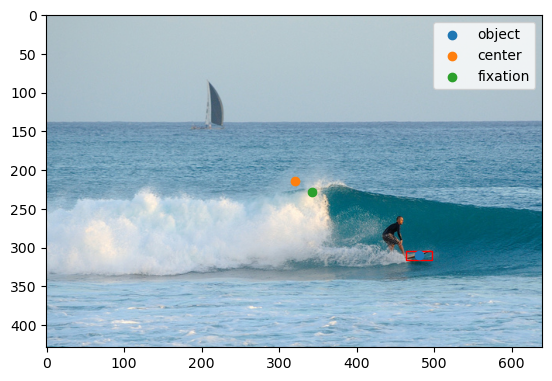

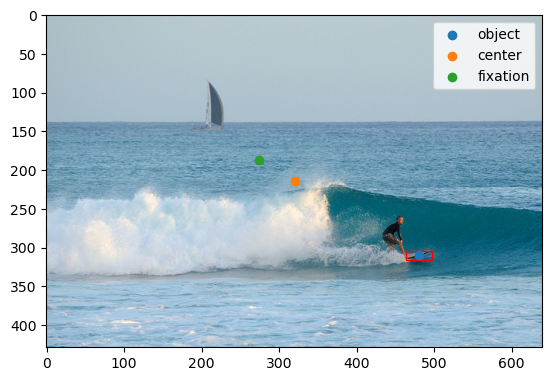

(274.2016978289894, 186.52101869739363)

In [30]:
find_fixation_location(im,bbx_xywh, 5, 16,plot=True)
find_fixation_location(im,bbx_xywh, 10, 16,plot=True)
find_fixation_location(im,bbx_xywh, 15, 16,plot=True)

## All Images

In [31]:
imfolder = '/home/gridsan/vdutell/RosenholtzLab_shared/cocop_stims'
imlist = glob.glob(f'{imfolder}/*.jpg', recursive=False)
len(imlist)

44

In [32]:
import pandas as pd
bounding_box_list = '/home/gridsan/vdutell/RosenholtzLab_shared/COCOPStims.csv'

bbx_list = pd.read_table(bounding_box_list,delimiter=',',header=None)
bbx_list.columns = ['image_name','object_name','index','bbx_x_16','bbx_y_16','bbx_w_16','bbx_h_16','used']
bbx_list.drop(columns='used')

rmlist = ['000000415536.jpg','000000514376.jpg','000000548524.jpg','000000567640.jpg','000000183965.jpg']
print(bbx_list.shape)
bbx_list = bbx_list[~bbx_list['image_name'].isin(rmlist)]
print(bbx_list.shape)


(41, 8)
(41, 8)


In [33]:
#create empty columns

#imsizes
bbx_list['imsize_x_16'] = ''
bbx_list['imsize_y_16'] = ''
bbx_list['imsize_x_22'] = ''
bbx_list['imsize_y_22'] = ''

#bounding boxes
bbx_list['bbx_x_22'] = ''
bbx_list['bbx_y_22'] = ''
bbx_list['bbx_w_22'] = ''
bbx_list['bbx_h_22'] = ''

#fixation locations
for ecc in [5,10,15]:
    for ppd in [16,22]:
        bbx_list[f'fx_x_{ppd}_{ecc}'] = ''
        bbx_list[f'fx_y_{ppd}_{ecc}'] = ''

#fill in values
for imname in bbx_list.image_name:
    #read in image
    im = cv2.imread(f'/home/gridsan/vdutell/RosenholtzLab_shared/cocop_stims/{imname}')
    if(im is not None):
        im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB) 
        row = bbx_list.loc[bbx_list['image_name'] == imname]
        x = row['bbx_x_16'].item()
        y = row['bbx_y_16'].item()
        w = row['bbx_w_16'].item()
        h = row['bbx_h_16'].item()
        bbx_xywh = [x,y,w,h]
        #print(bbx_xywh)
        #loop through eccentricities
        for ppds in [16,22]:
            if(ppds==22):
                #resize image
                (imsize_y,imsize_x, _) = np.round(np.multiply(np.shape(im), (22/16))).astype(int)
                #imsize_x = int(np.shape(im)[1]*(22/16))
                #imsize_y = int(np.shape(im)[0]*(22/16))
                im = cv2.resize(im,(imsize_x,imsize_y))
                #plt.imshow(im)
                #plt.show()
                #calculate new bounding box
                bbx_xywh = np.round(np.multiply(bbx_xywh, (22/16))).astype(int)
                bbx_list.loc[bbx_list['image_name'] == imname, f'bbx_x_{ppds}'] = bbx_xywh[0]
                bbx_list.loc[bbx_list['image_name'] == imname, f'bbx_y_{ppds}'] = bbx_xywh[1]
                bbx_list.loc[bbx_list['image_name'] == imname, f'bbx_w_{ppds}'] = bbx_xywh[2]
                bbx_list.loc[bbx_list['image_name'] == imname, f'bbx_h_{ppds}'] = bbx_xywh[3]
            #image sizes
            bbx_list.loc[bbx_list['image_name'] == imname, f'imsize_x_{ppds}'] = np.shape(im)[1]
            bbx_list.loc[bbx_list['image_name'] == imname, f'imsize_y_{ppds}'] = np.shape(im)[0]
            for ecc in [5,10,15]:
                fx_x, fx_y = find_fixation_location(im, bbx_xywh, ecc, ppds, plot=False)
                #print(fx_x, fx_y)
                #bbx_list[f'fx_x_{ppds}_{ecc}'] = fx_x
                #bbx_list[f'fx_y_{ppds}_{ecc}'] = fx_y
                bbx_list.loc[bbx_list['image_name'] == imname, f'fx_x_{ppds}_{ecc}'] = fx_x
                bbx_list.loc[bbx_list['image_name'] == imname, f'fx_y_{ppds}_{ecc}'] = fx_y

    else:
        print(imname)
        


        

In [34]:
#bbx_list['image_name'==imname]
bbx_list
bbx_list.to_csv(f'/home/gridsan/vdutell/RosenholtzLab_shared/cocop_bbx_fixations.csv',index=False)

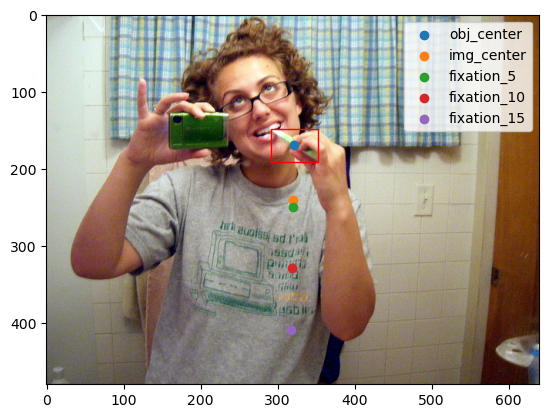

In [35]:
## Test it out (16pdd)
#imnum = '000000409211'
#imnum =  '000000532761'
#imnum = '000000543581'
#imnum = '000000416837'
#imnum = '000000545958' #cow
# imnum = '000000067213'
# imnum = '000000335529'
# imnum = '000000391290'
# imnum = '000000577864'
# imnum = '000000569059'
# imnum = '000000391290'
# imnum = '000000577932'
imnum = '000000507473'

im = cv2.imread(f'/home/gridsan/vdutell/RosenholtzLab_shared/cocop_stims/{imnum}.jpg')
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB) 

fig,ax = plt.subplots()
ax.imshow(im)
row = bbx_list.loc[bbx_list['image_name'] == f'{imnum}.jpg']
rect = patches.Rectangle((row['bbx_x_16'].item(),
                          row['bbx_y_16'].item()),
                          row['bbx_w_16'].item(),
                          row['bbx_h_16'].item(), linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)
plt.scatter(row['bbx_x_16'].item() + row['bbx_w_16'].item()//2, row['bbx_y_16'].item() + row['bbx_h_16'].item()//2,label='obj_center')
plt.scatter(row['imsize_x_16'].item()//2, row['imsize_y_16'].item()//2,label='img_center')
for ecc in [5,10,15]:
    plt.scatter(row[f'fx_x_16_{ecc}'].item(),row[f'fx_y_16_{ecc}'].item(),label=f'fixation_{ecc}')
plt.legend()
plt.show()

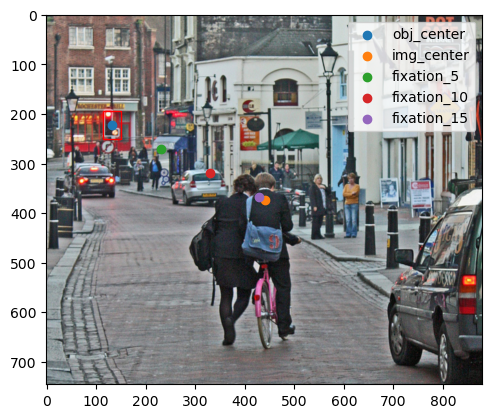

In [39]:
## Test it out (22pdd)
#imnum =  '000000532761'
#imnum = '000000409211'
#imnum = '000000543581'
imnum = '000000577932'

im = cv2.imread(f'/home/gridsan/vdutell/RosenholtzLab_shared/cocop_stims/{imnum}.jpg')
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB) 

imsize_y = int(np.shape(im)[0]*(22/16))
imsize_x = int(np.shape(im)[1]*(22/16))
im = cv2.resize(im,(imsize_x,imsize_y))

fig,ax = plt.subplots()
ax.imshow(im)
row = bbx_list.loc[bbx_list['image_name'] == f'{imnum}.jpg']
rect = patches.Rectangle((row['bbx_x_22'].item(),
                          row['bbx_y_22'].item()),
                          row['bbx_w_22'].item(),
                          row['bbx_h_22'].item(), linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)
plt.scatter(row['bbx_x_22'].item() + row['bbx_w_22'].item()//2, row['bbx_y_22'].item() + row['bbx_h_22'].item()//2,label='obj_center')
plt.scatter(row['imsize_x_22'].item()//2, row['imsize_y_22'].item()//2,label='img_center')
for ecc in [5,10,15]:
    plt.scatter(row[f'fx_x_22_{ecc}'].item(),row[f'fx_y_22_{ecc}'].item(),label=f'fixation_{ecc}')
plt.legend()
plt.show()

112.61308937953538 240.14022014565143
187.22617875907076 211.28044029130282
261.83926813860614 182.42066043695422


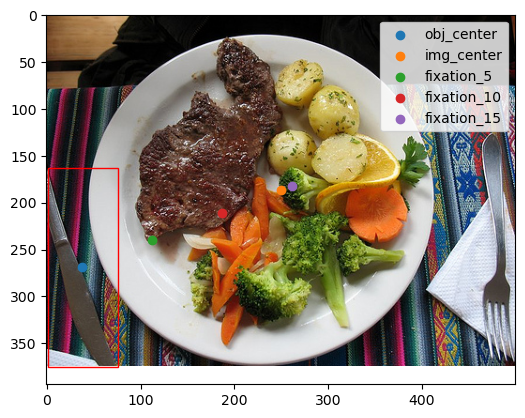

In [40]:
## Test it out (16pdd)
#imnum = '000000409211'
#imnum =  '000000532761'
#imnum = '000000543581'
#imnum = '000000416837'
#imnum = '000000545958' #cow
#imnum = '000000067213'
imnum = '000000104669'

im = cv2.imread(f'/home/gridsan/vdutell/RosenholtzLab_shared/cocop_stims/{imnum}.jpg')
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB) 

fig,ax = plt.subplots()
ax.imshow(im)
row = bbx_list.loc[bbx_list['image_name'] == f'{imnum}.jpg']
rect = patches.Rectangle((row['bbx_x_16'].item(),
                          row['bbx_y_16'].item()),
                          row['bbx_w_16'].item(),
                          row['bbx_h_16'].item(), linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)
plt.scatter(row['bbx_x_16'].item() + row['bbx_w_16'].item()//2, row['bbx_y_16'].item() + row['bbx_h_16'].item()//2,label='obj_center')
plt.scatter(row['imsize_x_16'].item()//2, row['imsize_y_16'].item()//2,label='img_center')
for ecc in [5,10,15]:
    print(row[f'fx_x_16_{ecc}'].item(),row[f'fx_y_16_{ecc}'].item())
    plt.scatter(row[f'fx_x_16_{ecc}'].item(),row[f'fx_y_16_{ecc}'].item(),label=f'fixation_{ecc}')
plt.legend()
plt.show()

In [41]:
im = cv2.imread(f'/home/gridsan/vdutell/RosenholtzLab_shared/cocop_stims/{imnum}.jpg')
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB) 
im.shape

(375, 500, 3)

In [42]:
row

,image_name,object_name,index,bbx_x_16,bbx_y_16,bbx_w_16,bbx_h_16,used,imsize_x_16,imsize_y_16,...,fx_x_22_5,fx_y_22_5,fx_x_16_10,fx_y_16_10,fx_x_22_10,fx_y_22_10,fx_x_16_15,fx_y_16_15,fx_x_22_15,fx_y_22_15
13,000000104669.jpg,knife,3,1,163,75,212,1,500,375,...,154.704234,330.606595,187.226179,211.28044,257.408468,291.21319,261.839268,182.42066,360.112702,251.819786
